In [107]:
import torch
import torchsummary
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2

import os
import math
import glob

In [108]:
########################################
#           Hyperparameters            #
########################################

NUM_EPOCHS = 200
BATCH_SIZE = 128
IMG_SIZE = 256


rng = np.random.default_rng()

In [109]:
########################################
#      Load the data directories       #
########################################

transform = transforms.Compose([
            # transforms.RandomHorizontalFlip(), # Flip the data horizontally
            transforms.ToPILImage(),
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            # transforms.RandomAdjustSharpness(0.25),
            transforms.RandomHorizontalFlip(0.5),
            # transforms.RandomVerticalFlip(0.5),
            transforms.ToTensor(),
            # transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ])

# Load the data of source birds (sitting)
root = '..\\data\\caltech_crop_birds\\'
source_dirs = glob.glob(root + '**/*.jpg', recursive=True)
source_dirs = np.array(source_dirs)
source_dirs = source_dirs.flatten()
rng.shuffle(source_dirs)

# Load the data of target birds (flying)
root = '..\\data\\birds1\\'
target_dirs = glob.glob(root + '**/*', recursive=True)
target_dirs = np.array(target_dirs)
target_dirs = target_dirs.flatten()
rng.shuffle(target_dirs)

# Transfer the extra images from source to target
transfer_count = (len(source_dirs) - len(target_dirs)) // 2
target_dirs = np.concatenate((target_dirs, source_dirs[:transfer_count]))
source_dirs = source_dirs[transfer_count:]

assert len(source_dirs) == len(target_dirs)

# Combine the list
source_dirs = np.expand_dims(source_dirs, axis=1)
target_dirs = np.expand_dims(target_dirs, axis=1)

data_dirs = np.concatenate((source_dirs, target_dirs), axis=1)

# data_list = np.array(data.imgs)

# Get the indices for the train/val/test split of 75/15/15
test_size = 100

train_split = math.floor(1 * len(data_dirs)) - test_size
val_split = math.ceil(0.00 * len(data_dirs))
test_split = val_split * 0 + test_size

# print(train_split + val_split + test_split, len(data_arr))

# Make sure the splits are correct
assert train_split + val_split + test_split == len(data_dirs)

# Split the dataset randomely
generator = torch.Generator().manual_seed(1)
train, val, test = torch.utils.data.random_split(data_dirs, [train_split, val_split, test_split], generator=generator)

len(train), len(val), len(test)

(9361, 0, 100)

In [110]:
print(data_dirs)

[['..\\data\\caltech_crop_birds\\175.Pine_Warbler\\Pine_Warbler_0025_171110.jpg'
  '..\\data\\birds1\\frame_4291.jpg']
 ['..\\data\\caltech_crop_birds\\106.Horned_Puffin\\Horned_Puffin_0069_101018.jpg'
  '..\\data\\birds1\\frame_2567.jpg']
 ['..\\data\\caltech_crop_birds\\052.Pied_billed_Grebe\\Pied_Billed_Grebe_0023_35687.jpg'
  '..\\data\\birds1\\BirdsFlying_735.jpg']
 ...
 ['..\\data\\caltech_crop_birds\\146.Forsters_Tern\\Forsters_Tern_0068_152078.jpg'
  '..\\data\\caltech_crop_birds\\160.Black_throated_Blue_Warbler\\Black_Throated_Blue_Warbler_0037_161707.jpg']
 ['..\\data\\caltech_crop_birds\\163.Cape_May_Warbler\\Cape_May_Warbler_0084_163132.jpg'
  '..\\data\\caltech_crop_birds\\112.Great_Grey_Shrike\\Great_Grey_Shrike_0019_797049.jpg']
 ['..\\data\\caltech_crop_birds\\127.Savannah_Sparrow\\Savannah_Sparrow_0029_119621.jpg'
  '..\\data\\caltech_crop_birds\\084.Red_legged_Kittiwake\\Red_Legged_Kittiwake_0048_73770.jpg']]


In [111]:
class GenData(torch.utils.data.Dataset):
    '''
    Data set class to store the feature maps
    '''

    def __init__(self, data, transform=None):
        # data = np.array(in_data)
        self.input_dirs = data
        self.transform = transform

        size = len(self.input_dirs) // 2

        # Number of sources and targets must be the same
        assert size % 2 == 0

        self.sources = self.input_dirs[:size]
        self.targets = self.input_dirs[size:]


    def __len__(self):
        return len(self.sources)
    
    def read_img(self, dir):
        img = cv2.imread(dir)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        return img

    def __getitem__(self, idx):

        source_dir = self.input_dirs[idx][0]
        target_dir = self.input_dirs[idx][1]

        source = self.read_img(source_dir)
        target = self.read_img(target_dir)

        if self.transform:
            source = self.transform(source)
            target = self.transform(target)

        return source, target
        
# Create data loaders
def get_data_loaders(batch_size=1):
    
    train_data = GenData(data_dirs[train.indices], transform=transform)
    val_data = GenData(data_dirs[val.indices], transform=transform)
    test_data = GenData(data_dirs[test.indices], transform=transform)

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    return train_dataloader, val_dataloader, test_dataloader

In [112]:
train_loader, valid_loader, test_loader = get_data_loaders(batch_size=BATCH_SIZE)

In [113]:
# Checking the dataset

    
# Checking the dataset
print('Validation Set:\n')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

print('\nTraining Set:')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

Validation Set:


Testing Set:
Image batch dimensions: torch.Size([50, 3, 256, 256])
Image label dimensions: torch.Size([50, 3, 256, 256])

Training Set:
Image batch dimensions: torch.Size([128, 3, 256, 256])
Image label dimensions: torch.Size([128, 3, 256, 256])


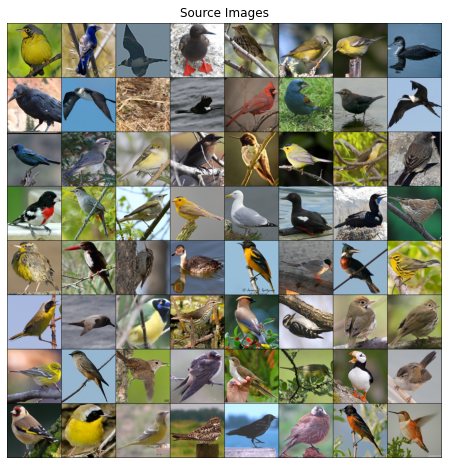

In [114]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Source Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64], 
                                         padding=2, normalize=False),
                        (1, 2, 0)))

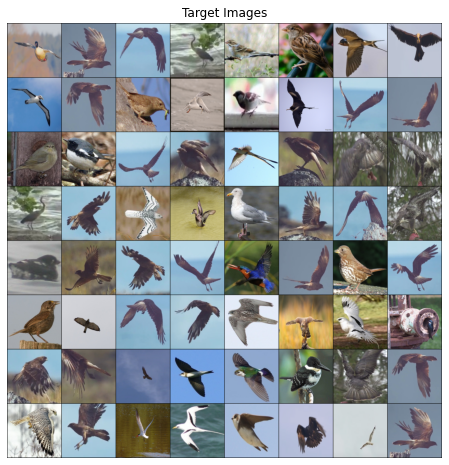

In [115]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Target Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(labels[:64], 
                                         padding=2, normalize=False),
                        (1, 2, 0)))